## Instructions
We need for all feature maps the following parameters: receptive field size (rf), effective stride (stride) and effective padding (padding).  
Computing this turned out to be tedious. For example the code below did not produce the effective padding parameter and it is not clear (to me) how to get this from these values. Therefor let's stick to the same tool the authors of DELF/DELG used. However, this did not work with the recent tensorflow versions. Therefore clone the fork from [github](https://github.com/eymarkfr/receptive_field) and follow the install instructions. 

#### Results (with auto encoder layer)
**layer2_conv1**: rf: 43, stride: 16, padding: 17  
**layer3_conv1**: rf: 99, stride: 16, padding: 49  
**layer4_conv1**: rf: 355, stride: 16, padding 145

In [15]:
import tensorflow as tf
import tensorflow.compat.v1 as tf_compat
from google.protobuf import text_format
import receptive_field as rf

In [2]:
def FreezeModel(model, filename):
    def _get_name(tensors):
        t = tensors[0]
        name = t.name 
        return name.split(":")[0]
    model_func = tf.function(lambda x: model(x))
    model_func = model_func.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
    frozen_func = tf.python.framework.convert_to_constants.convert_variables_to_constants_v2(model_func)
    frozen_func.graph.as_graph_def()
    input_node = frozen_func.inputs
    output_node = frozen_func.outputs
    print(f'Inputs: {input_node}')
    print(f'Outputs: {output_node}')
    tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
        logdir=".",
        name=filename,
        as_text=True)
    return _get_name(input_node), _get_name(output_node)

In [3]:
def GetParameters(filename, input_node, output_node):
    def _load_graphdef():
        graph_def = tf_compat.GraphDef()
        pbstr = tf_compat.gfile.Open(filename).read()
        text_format.Parse(pbstr, graph_def)
        return graph_def
    graph_def = _load_graphdef()
    (receptive_field_x, receptive_field_y, effective_stride_x, effective_stride_y, effective_padding_x, effective_padding_y) = rf.compute_receptive_field_from_graph_def(graph_def, input_node, output_node)

    print(f"Results for {filename}")
    print(f"rf: {receptive_field_x} x {receptive_field_y}")
    print(f"stride: {effective_stride_x} x {effective_stride_y}")
    print(f"padding: {effective_padding_x} x {effective_padding_y}")


In [4]:
# We start by creating a .pbtxt model for all layers we need the parameters for. This was the most stable way of getting results
encoded_channels = 16 # This should not matter for the receptive field
layer = 'conv3_block1_1_conv'
filename = f'{layer}.pbtxt'
net = tf.keras.applications.resnet50.ResNet50(include_top=False)
early = net.get_layer(layer).output
early = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2))(early)
early = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(early)
model = tf.keras.Model(inputs=net.input, outputs=early)

input_node, output_node = FreezeModel(model, filename)
print(input_node)
GetParameters(filename, input_node, output_node)

Inputs: [<tf.Tensor 'x:0' shape=(None, None, None, 3) dtype=float32>]
Outputs: [<tf.Tensor 'Identity:0' shape=(None, None, None, 16) dtype=float32>]
x
functional_1/conv2d/Conv2D/ReadVariableOp
functional_1/conv3_block1_1_conv/Conv2D/ReadVariableOp
functional_1/conv2_block3_3_conv/Conv2D/ReadVariableOp
functional_1/conv2_block3_2_conv/Conv2D/ReadVariableOp
functional_1/conv2_block3_1_conv/Conv2D/ReadVariableOp
functional_1/conv2_block2_3_conv/Conv2D/ReadVariableOp
functional_1/conv2_block2_2_conv/Conv2D/ReadVariableOp
functional_1/conv2_block2_1_conv/Conv2D/ReadVariableOp
functional_1/conv2_block1_3_conv/Conv2D/ReadVariableOp
functional_1/conv2_block1_2_conv/Conv2D/ReadVariableOp
functional_1/conv2_block1_0_conv/Conv2D/ReadVariableOp
functional_1/conv2_block1_1_conv/Conv2D/ReadVariableOp
functional_1/conv1_conv/Conv2D/ReadVariableOp
Results for conv3_block1_1_conv.pbtxt
rf: 43 x 43
stride: 16 x 16
padding: 17 x 17


In [5]:
# We start by creating a .pbtxt model for all layers we need the parameters for. This was the most stable way of getting results
encoded_channels = 16 # This should not matter for the receptive field
layer = 'conv4_block1_1_conv'
filename = f'{layer}.pbtxt'
net = tf.keras.applications.resnet50.ResNet50(include_top=False)
middle = net.get_layer(layer).output
middle = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(middle)
model = tf.keras.Model(inputs=net.input, outputs=middle)

input_node, output_node = FreezeModel(model, filename)
print(input_node)
GetParameters(filename, input_node, output_node)

Inputs: [<tf.Tensor 'x:0' shape=(None, None, None, 3) dtype=float32>]
Outputs: [<tf.Tensor 'Identity:0' shape=(None, None, None, 16) dtype=float32>]
x
functional_3/conv2d_1/Conv2D/ReadVariableOp
functional_3/conv4_block1_1_conv/Conv2D/ReadVariableOp
functional_3/conv3_block4_3_conv/Conv2D/ReadVariableOp
functional_3/conv3_block4_2_conv/Conv2D/ReadVariableOp
functional_3/conv3_block4_1_conv/Conv2D/ReadVariableOp
functional_3/conv3_block3_3_conv/Conv2D/ReadVariableOp
functional_3/conv3_block3_2_conv/Conv2D/ReadVariableOp
functional_3/conv3_block3_1_conv/Conv2D/ReadVariableOp
functional_3/conv3_block2_3_conv/Conv2D/ReadVariableOp
functional_3/conv3_block2_2_conv/Conv2D/ReadVariableOp
functional_3/conv3_block2_1_conv/Conv2D/ReadVariableOp
functional_3/conv3_block1_3_conv/Conv2D/ReadVariableOp
functional_3/conv3_block1_2_conv/Conv2D/ReadVariableOp
functional_3/conv3_block1_0_conv/Conv2D/ReadVariableOp
functional_3/conv3_block1_1_conv/Conv2D/ReadVariableOp
functional_3/conv2_block3_3_conv/Co

In [17]:
# We start by creating a .pbtxt model for all layers we need the parameters for. This was the most stable way of getting results
# DANGER!!! Upsampling makes things trickier!!! I'm not sure if my adaptions work the right way
encoded_channels = 16 # This should not matter for the receptive field
layer = 'conv5_block1_1_conv'
filename = f'{layer}.pbtxt'
net = tf.keras.applications.resnet50.ResNet50(include_top=False)
deep = net.get_layer(layer).output
deep = tf.keras.layers.UpSampling2D(interpolation='bilinear')(deep)
deep = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(deep)
model = tf.keras.Model(inputs=net.input, outputs=deep)

input_node, output_node = FreezeModel(model, filename)
print(input_node)
GetParameters(filename, input_node, output_node)

Inputs: [<tf.Tensor 'x:0' shape=(None, None, None, 3) dtype=float32>]
Outputs: [<tf.Tensor 'Identity:0' shape=(None, None, None, 16) dtype=float32>]
x
functional_25/conv2d_11/Conv2D/ReadVariableOp
functional_25/conv5_block1_1_conv/Conv2D/ReadVariableOp
functional_25/conv4_block6_3_conv/Conv2D/ReadVariableOp
functional_25/conv4_block6_2_conv/Conv2D/ReadVariableOp
functional_25/conv4_block6_1_conv/Conv2D/ReadVariableOp
functional_25/conv4_block5_3_conv/Conv2D/ReadVariableOp
functional_25/conv4_block5_2_conv/Conv2D/ReadVariableOp
functional_25/conv4_block5_1_conv/Conv2D/ReadVariableOp
functional_25/conv4_block4_3_conv/Conv2D/ReadVariableOp
functional_25/conv4_block4_2_conv/Conv2D/ReadVariableOp
functional_25/conv4_block4_1_conv/Conv2D/ReadVariableOp
functional_25/conv4_block3_3_conv/Conv2D/ReadVariableOp
functional_25/conv4_block3_2_conv/Conv2D/ReadVariableOp
functional_25/conv4_block3_1_conv/Conv2D/ReadVariableOp
functional_25/conv4_block2_3_conv/Conv2D/ReadVariableOp
functional_25/conv4

### Code below deprecated but kept as reference

In [8]:
# from receptivefield.keras import KerasReceptiveField
# from receptivefield.image import get_default_image
# from torchvision import models
# import numpy as np
# import tensorflow as tf
# from lib.tf_weight_loader import mapping

In [9]:
# # numerically we need to make sure that it can fit within the 
# # input shape
# input_shape = [512, 512, 3] 
# default_mapping = mapping.get_default_mapping()

In [10]:
rnet = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None)
print(rnet.summary())

0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, None, None, 5 0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, None, None, 2 131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, None, None, 2 1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, None, None, 2 0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, None, None, 2 590080      conv4_block1_1_relu[0][0]      

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
# encoded_channels = 16 # This should not matter for the receptive field
# def build_model_func(input_shape):
#     rnet = tf.keras.applications.resnet50.ResNet50(include_top=False)
#     inp = tf.keras.layers.Input(shape=input_shape, name='input_image')
#     early = rnet.get_layer('conv3_block1_1_conv').output
#     middle = rnet.get_layer('conv4_block1_1_conv').output
#     deep = rnet.get_layer('conv5_block1_1_conv').output
    
#     part_model = tf.keras.Model(inputs=rnet.input, outputs=[early, middle, deep])
#     early, middle, deep = part_model(inp)
    
#     early = tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2))(early)
#     early = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(early)
    
#     middle = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(middle)
    
#     deep = tf.keras.layers.UpSampling2D(interpolation='nearest')(deep)
#     #deep = tf.keras.layers.Conv2DTranspose(kernel_size=(2,2), filters=512, strides=(2,2))(deep)
#     deep = tf.keras.layers.Conv2D(filters=encoded_channels, kernel_size=(1,1))(deep)
    
#     early = tf.keras.layers.Layer(name="early")(early)
#     middle = tf.keras.layers.Layer(name="middle")(middle)
#     deep = tf.keras.layers.Layer(name="deep")(deep)
#     return tf.keras.Model(inputs = inp, outputs=[early, middle, deep])

# # Test
# model = build_model_func(input_shape)
# print(model.summary())

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       [(None, None, None,  9113984     input_image[0][0]                
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 32, 32, 128)  0           functional_7[0][0]               
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 512)  0           functional_7[0][2]               
_______________________________________________________________________________________

128, 128)
[2021-01-04 10:44:09,583][ INFO][keras.py]::Running `setup_model_weights` on Layer: <class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>
[2021-01-04 10:44:09,585][WARNING][keras.py]::Setting weights for layer <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> is not supported.
[2021-01-04 10:44:09,587][WARNING][keras.py]::Layer conv3_block1_2_relu activation should be linear but is: relu
[2021-01-04 10:44:09,592][ INFO][keras.py]::Setting weights for layer `conv3_block1_0_conv` :: Conv2D(1, 1, 256, 512)
[2021-01-04 10:44:09,598][ INFO][keras.py]::Setting weights for layer `conv3_block1_3_conv` :: Conv2D(1, 1, 128, 512)
[2021-01-04 10:44:09,603][ INFO][keras.py]::Running `setup_model_weights` on Layer: <class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>
[2021-01-04 10:44:09,605][WARNING][keras.py]::Setting weights for layer <class 'tensorflow.python.training.tracking.data_structures.ListWrapper'> is not su

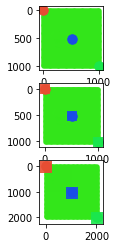

In [13]:
# rf = KerasReceptiveField(build_model_func, init_weights=True)
# rf_params = rf.compute((1024,1024,3), 'input_image', ['early', 'middle', 'deep'])
# # debug receptive field
# rf.plot_rf_grids(get_default_image((1024,1024,3), name='doge'))